In [1]:
import sys
import yaml
import os

import ta
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    log_loss,
    roc_auc_score,
    f1_score,
    mean_squared_error,
    accuracy_score,
    r2_score,
    mean_absolute_error,
)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# sys.path.insert(1, '/home/kenny/algotrading/backtesting')
sys.path.insert(1, '/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/src/data')
sys.path.insert(1, '/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/src/models')
sys.path.insert(1, '/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/src/configs')

In [3]:
from config import *
from model import Model
from dataset import Data
from data import get_actual_data, FEATURES, TARGET

In [4]:
def resample_ohlcv(interval, path_to_data):
    df = pd.read_csv(path_to_data, index_col=False)
    df.set_index(['Time'], inplace=True)
    df.set_index(pd.to_datetime(df.index), inplace=True)
    df = df.resample(interval).agg({
        'Open':'first',
        'High':'max',
        'Low':'min',
        'Close':'last',
        'Volume':'sum'
    })
    return df

In [5]:
path_data_dir = '/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/data/data_processed'

test_months = ["january", "february"]
train = []
test = []
for path in os.listdir(path_data_dir):
    if path == "data_1min.csv":
        continue
    month = path.split("_")[1]
    # df = pd.read_csv(os.path.join(path_data_dir, path), sep=',', index_col=False)
    df = resample_ohlcv('1min', os.path.join(path_data_dir, path))
    if month not in test_months:
        train.append(df)
    else:
        test.append(df)

train_df = pd.concat(train).sort_index()
test_df = pd.concat(test).sort_index()

In [6]:
train_df

,Open,High,Low,Close,Volume
Time,,,,,
2022-05-01 00:00:00,37630.80,37665.29,37612.43,37645.92,85.80484
2022-05-01 00:01:00,37645.92,37645.93,37622.48,37642.29,28.27385
2022-05-01 00:02:00,37642.28,37684.71,37642.28,37672.10,70.97044
2022-05-01 00:03:00,37672.11,37738.97,37661.89,37737.08,81.17584
2022-05-01 00:04:00,37737.09,37737.09,37700.74,37717.79,38.43930
...,...,...,...,...,...
2022-12-31 23:55:00,16540.42,16540.92,16537.71,16539.28,36.23683
2022-12-31 23:56:00,16538.65,16540.53,16538.38,16540.52,38.58840
2022-12-31 23:57:00,16540.52,16540.79,16535.05,16537.78,53.35978


In [7]:
test_df

,Open,High,Low,Close,Volume
Time,,,,,
2023-01-01 00:00:00,16541.77,16544.76,16538.45,16543.67,83.08143
2023-01-01 00:01:00,16543.04,16544.41,16538.48,16539.31,80.45300
2023-01-01 00:02:00,16539.31,16541.17,16534.52,16536.43,62.90197
2023-01-01 00:03:00,16536.43,16537.28,16531.00,16533.65,115.71894
2023-01-01 00:04:00,16534.12,16536.08,16527.51,16535.38,144.45369
...,...,...,...,...,...
2023-02-24 15:09:00,23773.32,23779.31,23760.50,23760.92,289.45214
2023-02-24 15:10:00,23760.92,23765.65,23739.00,23751.00,436.08826
2023-02-24 15:11:00,23749.65,23758.98,23721.00,23752.17,600.05702


In [6]:
tss = TimeSeriesSplit(n_splits=5, test_size=30*24*60)
df = df.sort_index()

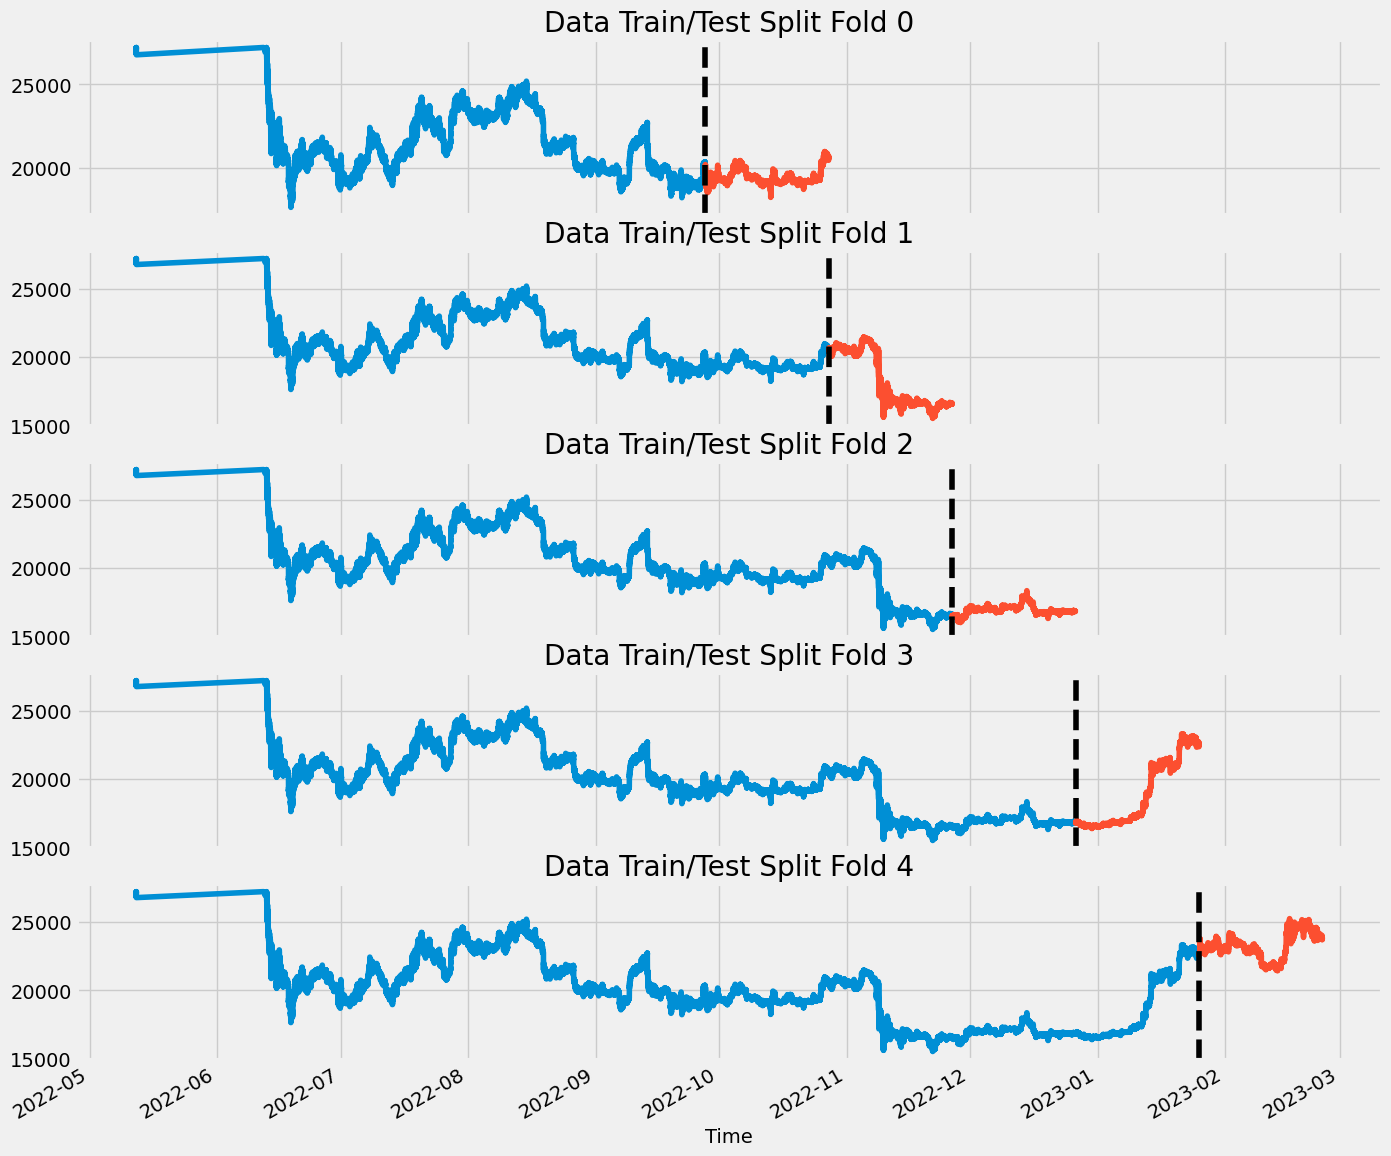

In [36]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True, )
fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Model training

In [8]:
data_train, data_test = Data(train_df), Data(test_df)
data_train.create_target(task_type='binary_classification')
data_test.create_target(task_type='binary_classification')
# data_train.create_target(task_type="multi_classification")
# data_test.create_target(task_type="multi_classification")
data_train.create_features()
data_test.create_features()

In [9]:
data_train.df.Target.value_counts()

0    177607
1    175193
Name: Target, dtype: int64

In [11]:
import json

# res_24 = '/home/kenny/algotrading/model_training/feature_exps_results/classification/LightGBM/res-24'
res_24 = "/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/reports/feature_exps_results/classification/LightGBM/res-24"
with open(res_24) as f:
    result = json.load(f)
features_24 = result['features']

In [9]:
model = Model(model_name='LightGBM')
optimization_results_path = '/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/reports/optimization_results'
model.optimize(data_train, optimization_results_path, features_24)

  0%|          | 0/4 [00:00<?, ?it/s]

[I 2023-05-16 19:25:59,324] A new study created in memory with name: classification LightGBM with metric - roc_auc


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.025771597085555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.025771597085555
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] early_stopping_round is set=383, early_stopping_rounds=383 will be ignored. Current value: early_stopping_round=383
[1]	valid_0's binary_logloss: 0.693055
[2]	valid_0's binary_logloss: 0.69295
[3]	valid_0's binary_logloss: 0.692906
[4]	valid_0's binary_logloss: 0.69284
[5]	v

[I 2023-05-16 19:26:13,351] Trial 0 finished with value: 0.5188715038629536 and parameters: {'n_estimators': 967, 'learning_rate': 0.06291335632869495, 'num_leaves': 2940, 'max_depth': 7, 'lambda_l1': 50, 'lambda_l2': 25, 'min_gain_to_split': 4.025771597085555, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5, 'early_stopping_rounds': 383}. Best is trial 0 with value: 0.5188715038629536.


[387]	valid_0's binary_logloss: 0.69271
[388]	valid_0's binary_logloss: 0.692714
[389]	valid_0's binary_logloss: 0.692714
[390]	valid_0's binary_logloss: 0.692714
[391]	valid_0's binary_logloss: 0.692702
[392]	valid_0's binary_logloss: 0.692702
[393]	valid_0's binary_logloss: 0.692702
[394]	valid_0's binary_logloss: 0.692702
[395]	valid_0's binary_logloss: 0.692702
[396]	valid_0's binary_logloss: 0.692702
[397]	valid_0's binary_logloss: 0.692702
[398]	valid_0's binary_logloss: 0.692702
[399]	valid_0's binary_logloss: 0.692689
[400]	valid_0's binary_logloss: 0.692689
[401]	valid_0's binary_logloss: 0.692689
[402]	valid_0's binary_logloss: 0.692689
[403]	valid_0's binary_logloss: 0.692689
[404]	valid_0's binary_logloss: 0.692675
[405]	valid_0's binary_logloss: 0.692675
[406]	valid_0's binary_logloss: 0.692675
[407]	valid_0's binary_logloss: 0.692675
[408]	valid_0's binary_logloss: 0.692675
[409]	valid_0's binary_logloss: 0.692675
[410]	valid_0's binary_logloss: 0.692675
[411]	valid_0's b

[I 2023-05-16 19:26:21,078] Trial 1 finished with value: 0.5197917336505087 and parameters: {'n_estimators': 989, 'learning_rate': 0.15311409453591215, 'num_leaves': 1420, 'max_depth': 11, 'lambda_l1': 50, 'lambda_l2': 75, 'min_gain_to_split': 11.174006546846297, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5, 'early_stopping_rounds': 149}. Best is trial 1 with value: 0.5197917336505087.


[144]	valid_0's binary_logloss: 0.692577
[145]	valid_0's binary_logloss: 0.692577
[146]	valid_0's binary_logloss: 0.692577
[147]	valid_0's binary_logloss: 0.692577
[148]	valid_0's binary_logloss: 0.692577
[149]	valid_0's binary_logloss: 0.692577
[150]	valid_0's binary_logloss: 0.692577
[151]	valid_0's binary_logloss: 0.692577
[152]	valid_0's binary_logloss: 0.692577
[153]	valid_0's binary_logloss: 0.69259
[154]	valid_0's binary_logloss: 0.69259
[155]	valid_0's binary_logloss: 0.69259
[156]	valid_0's binary_logloss: 0.69259
[157]	valid_0's binary_logloss: 0.69259
[158]	valid_0's binary_logloss: 0.69259
[159]	valid_0's binary_logloss: 0.69259
[160]	valid_0's binary_logloss: 0.69259
[161]	valid_0's binary_logloss: 0.69259
[162]	valid_0's binary_logloss: 0.69259
[163]	valid_0's binary_logloss: 0.69259
[164]	valid_0's binary_logloss: 0.69259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is s

[I 2023-05-16 19:26:28,023] Trial 2 finished with value: 0.5178644165023757 and parameters: {'n_estimators': 382, 'learning_rate': 0.23695700242147105, 'num_leaves': 1800, 'max_depth': 4, 'lambda_l1': 40, 'lambda_l2': 25, 'min_gain_to_split': 9.66400597234666, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'early_stopping_rounds': 251}. Best is trial 1 with value: 0.5197917336505087.


[247]	valid_0's binary_logloss: 0.69243
[248]	valid_0's binary_logloss: 0.69243
[249]	valid_0's binary_logloss: 0.69243
[250]	valid_0's binary_logloss: 0.69243
[251]	valid_0's binary_logloss: 0.69243
[252]	valid_0's binary_logloss: 0.69243
[253]	valid_0's binary_logloss: 0.69243
[254]	valid_0's binary_logloss: 0.69243
[255]	valid_0's binary_logloss: 0.69243
[256]	valid_0's binary_logloss: 0.69244
[257]	valid_0's binary_logloss: 0.69244
[258]	valid_0's binary_logloss: 0.69244
[259]	valid_0's binary_logloss: 0.69244
[260]	valid_0's binary_logloss: 0.69244
[261]	valid_0's binary_logloss: 0.69244
[262]	valid_0's binary_logloss: 0.69244
[263]	valid_0's binary_logloss: 0.69244
[264]	valid_0's binary_logloss: 0.69244
[265]	valid_0's binary_logloss: 0.69244
[266]	valid_0's binary_logloss: 0.69244
[267]	valid_0's binary_logloss: 0.69244
[268]	valid_0's binary_logloss: 0.69244
[269]	valid_0's binary_logloss: 0.69244
[270]	valid_0's binary_logloss: 0.69244
[271]	valid_0's binary_logloss: 0.69244


[I 2023-05-16 19:26:33,847] Trial 3 finished with value: 0.5151190208519807 and parameters: {'n_estimators': 382, 'learning_rate': 0.19517924576047435, 'num_leaves': 2160, 'max_depth': 6, 'lambda_l1': 90, 'lambda_l2': 30, 'min_gain_to_split': 4.717398480389382, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2, 'early_stopping_rounds': 81}. Best is trial 1 with value: 0.5197917336505087.


[52]	valid_0's binary_logloss: 0.692654
[53]	valid_0's binary_logloss: 0.692654
[54]	valid_0's binary_logloss: 0.692654
[55]	valid_0's binary_logloss: 0.692671
[56]	valid_0's binary_logloss: 0.692671
[57]	valid_0's binary_logloss: 0.692671
[58]	valid_0's binary_logloss: 0.692671
[59]	valid_0's binary_logloss: 0.692671
[60]	valid_0's binary_logloss: 0.692718
[61]	valid_0's binary_logloss: 0.692718
[62]	valid_0's binary_logloss: 0.692718
[63]	valid_0's binary_logloss: 0.692718
[64]	valid_0's binary_logloss: 0.692718
[65]	valid_0's binary_logloss: 0.692718
[66]	valid_0's binary_logloss: 0.692732
[67]	valid_0's binary_logloss: 0.692732
[68]	valid_0's binary_logloss: 0.692732
[69]	valid_0's binary_logloss: 0.692732
[70]	valid_0's binary_logloss: 0.69272
[71]	valid_0's binary_logloss: 0.69272
[72]	valid_0's binary_logloss: 0.692816
[73]	valid_0's binary_logloss: 0.692835
[74]	valid_0's binary_logloss: 0.692835
[75]	valid_0's binary_logloss: 0.692835
[76]	valid_0's binary_logloss: 0.692835
[7

[I 2023-05-16 19:26:45,061] Trial 4 finished with value: 0.5186271644411045 and parameters: {'n_estimators': 619, 'learning_rate': 0.2798876545714427, 'num_leaves': 1760, 'max_depth': 12, 'lambda_l1': 10, 'lambda_l2': 20, 'min_gain_to_split': 7.487396078944369, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'early_stopping_rounds': 414}. Best is trial 1 with value: 0.5197917336505087.


[380]	valid_0's binary_logloss: 0.693307
[381]	valid_0's binary_logloss: 0.693307
[382]	valid_0's binary_logloss: 0.693307
[383]	valid_0's binary_logloss: 0.693307
[384]	valid_0's binary_logloss: 0.693307
[385]	valid_0's binary_logloss: 0.693307
[386]	valid_0's binary_logloss: 0.693307
[387]	valid_0's binary_logloss: 0.693307
[388]	valid_0's binary_logloss: 0.693307
[389]	valid_0's binary_logloss: 0.693307
[390]	valid_0's binary_logloss: 0.693307
[391]	valid_0's binary_logloss: 0.693307
[392]	valid_0's binary_logloss: 0.693307
[393]	valid_0's binary_logloss: 0.693307
[394]	valid_0's binary_logloss: 0.693307
[395]	valid_0's binary_logloss: 0.693307
[396]	valid_0's binary_logloss: 0.693307
[397]	valid_0's binary_logloss: 0.693307
[398]	valid_0's binary_logloss: 0.693307
[399]	valid_0's binary_logloss: 0.693307
[400]	valid_0's binary_logloss: 0.693307
[401]	valid_0's binary_logloss: 0.693307
[402]	valid_0's binary_logloss: 0.693307
[403]	valid_0's binary_logloss: 0.693307
[404]	valid_0's 

[I 2023-05-16 19:26:55,785] Trial 5 finished with value: 0.5214065295060936 and parameters: {'n_estimators': 507, 'learning_rate': 0.1945272164205704, 'num_leaves': 640, 'max_depth': 5, 'lambda_l1': 95, 'lambda_l2': 50, 'min_gain_to_split': 0.8118754878362294, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2, 'early_stopping_rounds': 488}. Best is trial 5 with value: 0.5214065295060936.


[476]	valid_0's binary_logloss: 0.692865
[477]	valid_0's binary_logloss: 0.692865
[478]	valid_0's binary_logloss: 0.692865
[479]	valid_0's binary_logloss: 0.692865
[480]	valid_0's binary_logloss: 0.692865
[481]	valid_0's binary_logloss: 0.692865
[482]	valid_0's binary_logloss: 0.692865
[483]	valid_0's binary_logloss: 0.692865
[484]	valid_0's binary_logloss: 0.692782
[485]	valid_0's binary_logloss: 0.692782
[486]	valid_0's binary_logloss: 0.692782
[487]	valid_0's binary_logloss: 0.692782
[488]	valid_0's binary_logloss: 0.692782
[489]	valid_0's binary_logloss: 0.692805
[490]	valid_0's binary_logloss: 0.6928
[491]	valid_0's binary_logloss: 0.6928
[492]	valid_0's binary_logloss: 0.6928
[493]	valid_0's binary_logloss: 0.6928
[494]	valid_0's binary_logloss: 0.692815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.0717793973588488, min_split_gain=0.0 will be ignored. Current value: min_

[I 2023-05-16 19:27:07,754] Trial 6 finished with value: 0.5168817875108755 and parameters: {'n_estimators': 326, 'learning_rate': 0.1953223821832256, 'num_leaves': 1340, 'max_depth': 8, 'lambda_l1': 10, 'lambda_l2': 45, 'min_gain_to_split': 2.0717793973588488, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'early_stopping_rounds': 264}. Best is trial 5 with value: 0.5214065295060936.


[242]	valid_0's binary_logloss: 0.697546
[243]	valid_0's binary_logloss: 0.697017
[244]	valid_0's binary_logloss: 0.697019
[245]	valid_0's binary_logloss: 0.697034
[246]	valid_0's binary_logloss: 0.697045
[247]	valid_0's binary_logloss: 0.697091
[248]	valid_0's binary_logloss: 0.697086
[249]	valid_0's binary_logloss: 0.697086
[250]	valid_0's binary_logloss: 0.69703
[251]	valid_0's binary_logloss: 0.697071
[252]	valid_0's binary_logloss: 0.697098
[253]	valid_0's binary_logloss: 0.697224
[254]	valid_0's binary_logloss: 0.697195
[255]	valid_0's binary_logloss: 0.697227
[256]	valid_0's binary_logloss: 0.697163
[257]	valid_0's binary_logloss: 0.69723
[258]	valid_0's binary_logloss: 0.697209
[259]	valid_0's binary_logloss: 0.696816
[260]	valid_0's binary_logloss: 0.696816
[261]	valid_0's binary_logloss: 0.697044
[262]	valid_0's binary_logloss: 0.697044
[263]	valid_0's binary_logloss: 0.697174
[264]	valid_0's binary_logloss: 0.696689
[265]	valid_0's binary_logloss: 0.696775
[266]	valid_0's bi

[I 2023-05-16 19:27:14,315] Trial 7 finished with value: 0.5171356677696084 and parameters: {'n_estimators': 455, 'learning_rate': 0.05316175000284937, 'num_leaves': 2720, 'max_depth': 6, 'lambda_l1': 30, 'lambda_l2': 95, 'min_gain_to_split': 4.252710301930796, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'early_stopping_rounds': 59}. Best is trial 5 with value: 0.5214065295060936.


[79]	valid_0's binary_logloss: 0.692628
[80]	valid_0's binary_logloss: 0.692652
[81]	valid_0's binary_logloss: 0.692658
[82]	valid_0's binary_logloss: 0.692658
[83]	valid_0's binary_logloss: 0.692656
[84]	valid_0's binary_logloss: 0.69266
[85]	valid_0's binary_logloss: 0.692665
[86]	valid_0's binary_logloss: 0.692658
[87]	valid_0's binary_logloss: 0.692665
[88]	valid_0's binary_logloss: 0.692666
[89]	valid_0's binary_logloss: 0.692668
[90]	valid_0's binary_logloss: 0.692668
[91]	valid_0's binary_logloss: 0.692675
[92]	valid_0's binary_logloss: 0.692675
[93]	valid_0's binary_logloss: 0.692681
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.8204337696965722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8204337696965722
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [War

[I 2023-05-16 19:27:22,634] Trial 8 finished with value: 0.5150951302461465 and parameters: {'n_estimators': 397, 'learning_rate': 0.22060892882056546, 'num_leaves': 1340, 'max_depth': 3, 'lambda_l1': 15, 'lambda_l2': 30, 'min_gain_to_split': 3.8204337696965722, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2, 'early_stopping_rounds': 426}. Best is trial 5 with value: 0.5214065295060936.


[378]	valid_0's binary_logloss: 0.693489
[379]	valid_0's binary_logloss: 0.693489
[380]	valid_0's binary_logloss: 0.693489
[381]	valid_0's binary_logloss: 0.693489
[382]	valid_0's binary_logloss: 0.693489
[383]	valid_0's binary_logloss: 0.693489
[384]	valid_0's binary_logloss: 0.693489
[385]	valid_0's binary_logloss: 0.693489
[386]	valid_0's binary_logloss: 0.693489
[387]	valid_0's binary_logloss: 0.693489
[388]	valid_0's binary_logloss: 0.693489
[389]	valid_0's binary_logloss: 0.693489
[390]	valid_0's binary_logloss: 0.693489
[391]	valid_0's binary_logloss: 0.693489
[392]	valid_0's binary_logloss: 0.693489
[393]	valid_0's binary_logloss: 0.693489
[394]	valid_0's binary_logloss: 0.693489
[395]	valid_0's binary_logloss: 0.693489
[396]	valid_0's binary_logloss: 0.693489
[397]	valid_0's binary_logloss: 0.693489
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.034591057670518, min_sp

[I 2023-05-16 19:27:28,848] Trial 9 finished with value: 0.5177728473186543 and parameters: {'n_estimators': 301, 'learning_rate': 0.24618895882256894, 'num_leaves': 560, 'max_depth': 10, 'lambda_l1': 45, 'lambda_l2': 75, 'min_gain_to_split': 14.034591057670518, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5, 'early_stopping_rounds': 118}. Best is trial 5 with value: 0.5214065295060936.


[90]	valid_0's binary_logloss: 0.692517
[91]	valid_0's binary_logloss: 0.692517
[92]	valid_0's binary_logloss: 0.692517
[93]	valid_0's binary_logloss: 0.692552
[94]	valid_0's binary_logloss: 0.692552
[95]	valid_0's binary_logloss: 0.692552
[96]	valid_0's binary_logloss: 0.692552
[97]	valid_0's binary_logloss: 0.692552
[98]	valid_0's binary_logloss: 0.692552
[99]	valid_0's binary_logloss: 0.692552
[100]	valid_0's binary_logloss: 0.692552
[101]	valid_0's binary_logloss: 0.692552
[102]	valid_0's binary_logloss: 0.692552
[103]	valid_0's binary_logloss: 0.692552
[104]	valid_0's binary_logloss: 0.692552
[105]	valid_0's binary_logloss: 0.692552
[106]	valid_0's binary_logloss: 0.692552
[107]	valid_0's binary_logloss: 0.692552
[108]	valid_0's binary_logloss: 0.692552
[109]	valid_0's binary_logloss: 0.692552
[110]	valid_0's binary_logloss: 0.692552
[111]	valid_0's binary_logloss: 0.692552
[112]	valid_0's binary_logloss: 0.692552
[113]	valid_0's binary_logloss: 0.692552
[114]	valid_0's binary_log

In [11]:
# model = Model(model_name='LightGBM')
result = model.train(data_train, metric='roc_auc',features=features_24, is_optimized=True)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8118754878362294, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8118754878362294
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] early_stopping_round is set=488, early_stopping_rounds=488 will be ignored. Current value: early_stopping_round=488


In [12]:
result

0.5209544436686715

In [13]:
data_test.df["predicted"] = model.model_trained.predict(data_test.df[features_24])

Metric calc for binary classification:

In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
y_true = data_test.df["Target"]
y_predicted = data_test.df["predicted"]
roc_auc = roc_auc_score(y_true, y_predicted)
accuracy = accuracy_score(y_true, y_predicted)
f1 = f1_score(y_true, y_predicted)
print("ROC AUC score:", roc_auc)
print("Accuracy:", accuracy)
print("F1 score:", f1)

ROC AUC score: 0.5106109487525577
Accuracy: 0.5104354678801128
F1 score: 0.39850704313333546


Metric cal for multiclass classification:

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
y_true = data_test.df["Target"]
y_predicted = data_test.df["predicted"]
f1 = f1_score(y_true, y_predicted, average='weighted') # Weighted F1 score
# roc_auc = roc_auc_score(y_true, y_predicted, multi_class='ovr', average='weighted') # One-vs-Rest ROC-AUC score
accuracy = accuracy_score(y_true, y_predicted) 
# print("ROC AUC score:", roc_auc)
print("Accuracy:", accuracy)
print("F1 score:", f1)

Accuracy: 0.9736761827287287
F1 score: 0.9609736153309457


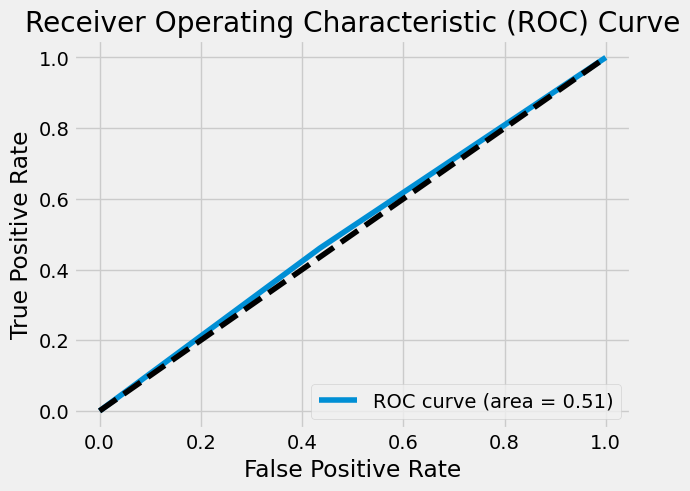

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_predicted)
roc_auc = roc_auc_score(y_true, y_predicted)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # plot the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


#### Saving model to onnx format

In [24]:
import onnxmltools
import onnx
from onnxmltools.convert.common.data_types import FloatTensorType, Int64TensorType

def custom_shape_calculator(input_shapes):
    # Calculate the output shape based on the input shape
    output_shape = (input_shapes[0][0], input_shapes[1][1])
    return output_shape

# initial_types = [("float_input", FloatTensorType([None, len(features_24)]))]
# custom_shape_calculators=[custom_shape_calculator]
initial_types = [("input", FloatTensorType([None, len(features_24)]))]
onnx_model = onnxmltools.convert_lightgbm(model.model_trained,initial_types=initial_types, target_opset=9)
path_to_model_onnx = '/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/models/multi_model_1_min.onnx'
onnxmltools.utils.save_model(onnx_model, path_to_model_onnx)

In [17]:
test = data_test.df[:20][features_24]
test.head()

,Open,High,Low,Volume,Close,SMA_3,SMA_5,SMA_15,SMA_30,SMA_50,...,close_1,close_2,close_3,close_4,close_5,high_1,high_2,high_3,high_4,high_5
Time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,16541.77,16544.76,16538.45,83.08143,16543.67,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:01:00,16543.04,16544.41,16538.48,80.45300,16539.31,NaN,NaN,NaN,NaN,NaN,...,16543.67,NaN,NaN,NaN,NaN,16544.76,NaN,NaN,NaN,NaN
2023-01-01 00:02:00,16539.31,16541.17,16534.52,62.90197,16536.43,16539.803333,NaN,NaN,NaN,NaN,...,16539.31,16543.67,NaN,NaN,NaN,16544.41,16544.76,NaN,NaN,NaN
2023-01-01 00:03:00,16536.43,16537.28,16531.00,115.71894,16533.65,16536.463333,NaN,NaN,NaN,NaN,...,16536.43,16539.31,16543.67,NaN,NaN,16541.17,16544.41,16544.76,NaN,NaN
2023-01-01 00:04:00,16534.12,16536.08,16527.51,144.45369,16535.38,16535.153333,16537.688,NaN,NaN,NaN,...,16533.65,16536.43,16539.31,16543.67,NaN,16537.28,16541.17,16544.41,16544.76,NaN


#### Inference model from onnx format

In [26]:
import onnxruntime as rt

session = rt.InferenceSession(path_to_model_onnx)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

pred_onnx = session.run( [output_name], {input_name: test.values.astype(np.float32)})[0]
pred_onnx

2023-05-16 16:53:09.410197 [W:onnxruntime:, execution_frame.cc:828 VerifyOutputSizes] Expected shape from model of {1} does not match actual shape of {20} for output label


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1], dtype=int64)

#### Check that predictions are equals

In [27]:
pred = model.model_trained.predict(test)
test["predicted"] = pred
test["onnx_predicted"] = pred_onnx
test

,Open,High,Low,Volume,Close,SMA_3,SMA_5,SMA_15,SMA_30,SMA_50,...,close_3,close_4,close_5,high_1,high_2,high_3,high_4,high_5,predicted,onnx_predicted
Time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,16541.77,16544.76,16538.45,83.08143,16543.67,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1
2023-01-01 00:01:00,16543.04,16544.41,16538.48,80.45300,16539.31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16544.76,NaN,NaN,NaN,NaN,-1.0,-1
2023-01-01 00:02:00,16539.31,16541.17,16534.52,62.90197,16536.43,16539.803333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16544.41,16544.76,NaN,NaN,NaN,-1.0,-1
2023-01-01 00:03:00,16536.43,16537.28,16531.00,115.71894,16533.65,16536.463333,NaN,NaN,NaN,NaN,...,16543.67,NaN,NaN,16541.17,16544.41,16544.76,NaN,NaN,-1.0,-1
2023-01-01 00:04:00,16534.12,16536.08,16527.51,144.45369,16535.38,16535.153333,16537.688,NaN,NaN,NaN,...,16539.31,16543.67,NaN,16537.28,16541.17,16544.41,16544.76,NaN,-1.0,-1
2023-01-01 00:05:00,16534.91,16537.80,16533.94,53.58957,16536.70,16535.243333,16536.294,NaN,NaN,NaN,...,16536.43,16539.31,16543.67,16536.08,16537.28,16541.17,16544.41,16544.76,-1.0,-1
2023-01-01 00:06:00,16536.76,16540.43,16534.20,96.45571,16535.91,16535.996667,16535.614,NaN,NaN,NaN,...,16533.65,16536.43,16539.31,16537.80,16536.08,16537.28,16541.17,16544.41,-1.0,-1
2023-01-01 00:07:00,16535.91,16539.69,16533.95,56.72010,16534.67,16535.760000,16535.262,NaN,NaN,NaN,...,16535.38,16533.65,16536.43,16540.43,16537.80,16536.08,16537.28,16541.17,-1.0,-1
2023-01-01 00:08:00,16533.98,16534.79,16528.00,95.13552,16529.28,16533.286667,16534.388,NaN,NaN,NaN,...,16536.70,16535.38,16533.65,16539.69,16540.43,16537.80,16536.08,16537.28,-1.0,-1


In [15]:
path_to_model_txt = '/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/models/binary_model_1_min.txt'
model.model_trained.booster_.save_model(path_to_model_txt)

In [16]:
lgb_classifier = lgb.Booster(model_file=path_to_model_txt)

In [18]:
lgb_classifier.predict(test[features_24].values.astype(np.float32))

array([0.43829834, 0.44020848, 0.44280431, 0.44450617, 0.44565141,
       0.44224274, 0.44135659, 0.44224274, 0.44135659, 0.4423131 ,
       0.4423131 , 0.44485782, 0.44485782, 0.51570081, 0.51976254,
       0.52411826, 0.52411826, 0.51976254, 0.47758569, 0.47589548])